# Bio_climate coupling

Simulates coupling between biology and climate, using Exok as 1D climate model

In [2]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import time
from IPython.utils import io
import xarray as xr
import gc

from Main_evolution_function_RK import *
from EXO_K_wo_ocean import *
from Constants import *
from Functions2 import *
from Functions import *
from Bio_model import *



%matplotlib notebook
plt.rcParams["figure.figsize"] = (7, 4)
mpl.rcParams['text.usetex'] = False
from cycler import cycler

colors = cycler('color', [plt.cm.inferno(i) for i in np.linspace(0.1, 1, 5)])
plt.rc('axes', axisbelow=True, grid=True, labelcolor='dimgray', labelweight='bold', prop_cycle=colors)
plt.rc('grid', linestyle='solid')
plt.rc('xtick', direction='in', color='dimgray')
plt.rc('ytick', direction='in', color='dimgray')
plt.rc('lines', linewidth=1.5)

In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator

# Charger le fichier CSV
df = pd.read_csv("Grid_values_ini.csv")

# Extraire les colonnes d'entrée et de sortie
points = df[['P', 'T', 'fG']].values
NCeq = df['NCeq'].values
cH = df['cH'].values
cC = df['cC'].values
cG = df['cG'].values
cN = df['cN'].values

# Création des interpolateurs
interp_NCeq = LinearNDInterpolator(points, NCeq)
interp_cH = LinearNDInterpolator(points, cH)
interp_cC = LinearNDInterpolator(points, cC)
interp_cG = LinearNDInterpolator(points, cG)
interp_cN = LinearNDInterpolator(points, cN)

# Fonction d'interpolation
def interp_conc(P, T, fG):
    pt = np.array([[P, T, fG]])
    return {
        'NC': interp_NCeq(pt)[0],
        'cH': interp_cH(pt)[0],
        'cC': interp_cC(pt)[0],
        'cG': interp_cG(pt)[0],
        'cN': interp_cN(pt)[0]
    }

In [3]:
# ==============================================================================================
# This script simulates the co-evolution of a planetary atmosphere and a biosphere on Mars.
# 
# Starting from an initial atmospheric state, it iteratively couples:
#   - A biological module that evolves depending on temperature, pressure, and gas composition
#   - A climate module that recalculates atmospheric equilibrium after biological activity
#
# Each loop runs until a specified CH₄ threshold is reached and equilibrium is re-evaluated.
# The simulation stops when surface temperature drops below 271 K (end of biological viability).
# All outputs (temperatures, concentrations, atmospheric profiles) are saved to a .pkl file.
# ==============================================================================================

t_beginning = time.time()


# Initial ocean properties
print("Volume of the ocean :", format(550 * Mars_surface, ".2e"), "m^3")
print("Ratio of the ocean over Mars surface :", round(fraction_ocean, 4))

# Initial atmospheric and surface conditions
T_surf = 300         # K
Ptop = 1.0           # Pa, top of atmosphere
Psurf = 2e5          # Pa, surface pressure
fH = 0.15            # Initial H2 fraction
fG = 0               # Initial CH4 fraction
fN = 0.01            # Initial N2 fraction
fC = 1 - fN - fG - fH  # Remaining CO2 fraction

# First radiative-convective equilibrium calculation
print('=================================== First equilibrium =================================================')
print('Calculating atmospheric equilibrium...')

with io.capture_output() as _:
    evol_mars = defining_atm(fH, fG, fN, Ptop, Psurf, T_surf, acceleration=None)
    evol_mars.equilibrate(Fnet_tolerance=0.1, verbose=False)

# Extract equilibrium results
teq, Teq, T_profile, P_profile = equilibrium_state_values(evol_mars)
del evol_mars
gc.collect()

print('Atmospheric equilibrium : P_surf =', round(P_profile[-1] / 1e5, 5), 'bar', ' and T_surf = ', round(Teq, 2), 'K')

# Compute atmospheric mass and altitudes
Z, dZ = compute_altitudes(P_profile, T_profile, 0.03706)
ntotgasfinal = atm_matter_quantity(P_profile, T_profile, dZ, 0.03706, Mars_surface)

# Initialization of storage variables
Teq_list = [Teq]
t_list = [0]
bio_all = []
atmo_all = []
times_all = []
press_all = []
medium_all = []
timesp_all = []
X_all = []

# Initial concentrations (mol/L)
cH, cC, cG, cN = 0, 0, 0, 0
NC = 1e4  # Initial cells concentration (cells/L)

# Initial state dictionary for the biological model
dico_ini = {'NC': 1e4,
            'cH': 0,
            'cC': 0,
            'cG': 0,
            'cN': 0}

# Get biological parameters at current temperature
Traits = ReturnTraits(Teq, Par, 1)
X0 = 2 * Traits[3]

# Number of iterations with logarithmic then linear CH₄ thresholds
niter1 = 20
niter2 = 50
CH4_threshold_list = np.concatenate([
    10**np.linspace(-7, -3, niter1),
    np.linspace(1.001e-3, 0.045, niter2)
])

# Main simulation loop
if Teq > 271:
    for i in range(niter1 + niter2):
        print('=================================== Iteration', i + 1, '/', niter1 + niter2, '===============================================')

        fgt = float(CH4_threshold_list[i])  # Target CH₄ threshold

        # Run coupled biology-atmosphere system
        Bio, Medium, Atmo, t, flux, flux_times, Pression = system_evolution_RK(
            Psurf, Teq, 550 * Mars_surface, 1 / 11 * fraction_ocean, 1e6, Mars_surface,
            ntotgasfinal, X0, CH4_frac_threshold=fgt,
            focean=fraction_ocean, Atm_compo=(fH, fC, fG, fN),
            concentration_ini=(dico_ini['cH'], dico_ini['cC'], dico_ini['cG'], dico_ini['cN']),
            NC_0=dico_ini['NC'], rtol=1e-7, atol=1e-20, methode='LSODA',
            N=int(1e5), firststep=None, minstep=np.nan
        )

        # Store results
        atmo_all.append(Atmo)
        times_all.append(t)
        bio_all.append(Bio[0])
        X_all.append(Bio[1])
        press_all.append(Pression)
        medium_all.append(Medium)
        timesp_all.append(flux_times)

        # Update simulation variables for next step
        tfinal = t[-1]
        ntotgasfinal = np.sum(Atmo[:, -1])
        fG = Atmo[2][-1] / ntotgasfinal
        fC = Atmo[1][-1] / ntotgasfinal
        fH = Atmo[0][-1] / ntotgasfinal
        fN = Atmo[3][-1] / ntotgasfinal
        X0 = Bio[1][-1]

        cG = Medium[2][-1] / (Mars_surface * 550 * 1e3)
        cC = Medium[1][-1] / (Mars_surface * 550 * 1e3)
        cH = Medium[0][-1] / (Mars_surface * 550 * 1e3)
        cN = Medium[3][-1] / (Mars_surface * 550 * 1e3)

        Psurf = Pression[-1]

        t_list.append(t_list[-1] + tfinal)
        print('fG', round(fG, 6))
        print('Calculating atmospheric equilibrium...')

        # Update climate based on new gas composition
        with io.capture_output() as _:
            evol_mars = defining_atm(fH, fG, fN, Ptop, Psurf, T_surf, acceleration=None)
            evol_mars.equilibrate(Fnet_tolerance=0.1, verbose=False)

        teq, Teq, T_profile, P_profile = equilibrium_state_values(evol_mars)
        T_surf = Teq

        print('Atmospheric equilibrium : P_surf =', round(P_profile[-1] / 1e5, 5), 'bar', ' and T_surf = ', round(Teq, 2), 'K')
        print("Actual time in years", round(t_list[-1] / 365.25, 2))

        del evol_mars
        gc.collect()

        # Update biological state via interpolation
        NC = Bio[0][-1]
        dico_ini = interp_conc(Psurf, Teq, fG)
        Teq_list.append(Teq)

        # Exit condition: surface becomes too cold for life
        if Teq < 271:
            break

    # Save data at the end of the simulation
    t_end = time.time()

    data = {
        "Teq_list": Teq_list,
        "press_all": press_all,
        "t_list": t_list,
        "bio_all": bio_all,
        "medium_all": medium_all,
        "atmo_all": atmo_all,
        "times_all": times_all,
        "timesp_all": timesp_all
    }

    task_id = 0
    filename = f"Couplage_exok_bio_file_niter1{niter1}_niter2{niter2}_id{task_id}.pkl"

    with open(filename, 'wb') as f:
        pickle.dump(data, f)

    # Final summary
    print('=========================================================================')
    print('               temps total', round(t_end - t_beginning, 2), 's')
    print('=========================================================================')
    print('=========================================================================')
    print('                           ***     END !     ***                         ')
    print('=========================================================================')

else:
    print("No life possible")


Volume of the ocean : 7.98e+16 m^3
Ratio of the ocean over Mars surface : 0.2985
=================================== First equilibrium =================================================
Calculating atmospheric equilibrium...
Atmospheric equilibrium : P_surf = 2.0 bar  and T_surf =  301.73 K
=================================== Iteration 1 / 6 ===============================================
RK3
Integration [!                                       ] (!) 211/100000 [0%] in 1.
[ 0.        0.100001  0.200002  0.300003  0.400004  0.500005  0.600006
  0.700007  0.800008  0.900009  1.00001   1.100011  1.200012  1.300013
  1.400014  1.500015  1.600016  1.700017  1.800018  1.900019  2.00002
  2.100021  2.200022  2.300023  2.400024  2.500025  2.600026  2.700027
  2.800028  2.900029  3.00003   3.100031  3.200032  3.300033  3.400034
  3.500035  3.600036  3.700037  3.800038  3.900039  4.00004   4.100041
  4.200042  4.300043  4.400044  4.500045  4.600046  4.700047  4.800048
  4.900049  5.00005   5.1000


KeyboardInterrupt



KeyboardInterrupt: 

### Plotting evolutions over time

In [ ]:
t_list_years = (np.array(t_list)/365.25)
step = 1
suff = ""

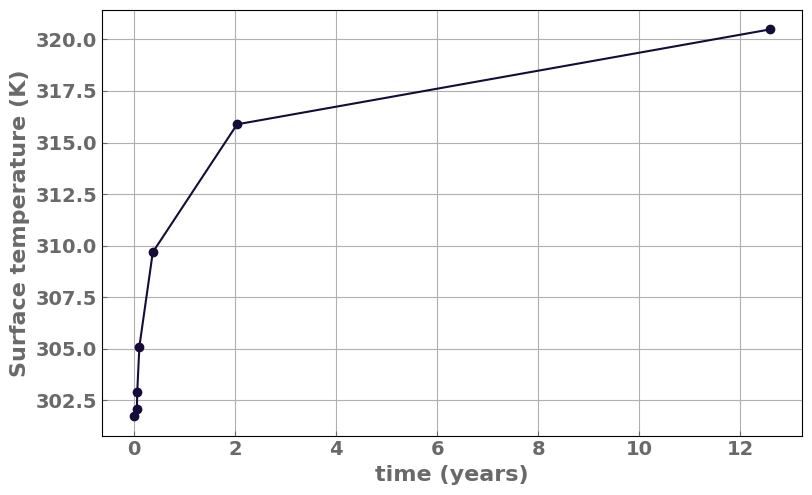

In [6]:
fig, ax = plt.subplots()

ax.plot(t_list_years , Teq_list, label='T')
ax.scatter(t_list_years , Teq_list)

# ax.legend(fontsize=14, frameon=True)
# for text in ax.get_legend().get_texts():
#     text.set_weight('bold')
ax.set_ylabel(f'Surface temperature (K)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()

ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')                   
plt.savefig(suff+"_1D_surface_temperature.png",dpi=300,bbox_inches='tight')

In [7]:
big_time_list = []
big_timep_list = []
big_ch4_atm_list = []
big_n2_atm_list = []
big_h2_atm_list = []
big_co2_atm_list = []
big_ch4_wat_list = []
big_n2_wat_list = []
big_h2_wat_list = []
big_co2_wat_list = []
big_pressure_list = []
big_NC_list = []
big_X_list = []

for i in range(len(t_list)-1):
    ttim = np.array(times_all[i])+t_list[i]
    ttim2 = np.array(timesp_all[i])+t_list[i]
    big_time_list = np.concatenate([big_time_list,ttim])
    big_timep_list = np.concatenate([big_timep_list,ttim2])
    big_ch4_atm_list = np.concatenate([big_ch4_atm_list,atmo_all[i][2]])
    big_n2_atm_list = np.concatenate([big_n2_atm_list,atmo_all[i][3]])
    big_h2_atm_list = np.concatenate([big_h2_atm_list,atmo_all[i][0]])
    big_co2_atm_list = np.concatenate([big_co2_atm_list,atmo_all[i][1]])
    big_ch4_wat_list = np.concatenate([big_ch4_wat_list,medium_all[i][2]])
    big_n2_wat_list = np.concatenate([big_n2_wat_list,medium_all[i][3]])
    big_h2_wat_list = np.concatenate([big_h2_wat_list,medium_all[i][0]])
    big_co2_wat_list = np.concatenate([big_co2_wat_list,medium_all[i][1]])
    big_pressure_list = np.concatenate([big_pressure_list,press_all[i]])
    big_NC_list = np.concatenate([big_NC_list,bio_all[i]])
    big_X_list = np.concatenate([big_X_list,X_all[i]])
    
big_time_list_years = np.array(big_time_list)/365.25
big_timep_list_years = np.array(big_timep_list)/365.25
big_ntotatm = np.array(big_ch4_atm_list) +np.array(big_co2_atm_list) + np.array(big_h2_atm_list) + np.array(big_n2_atm_list)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


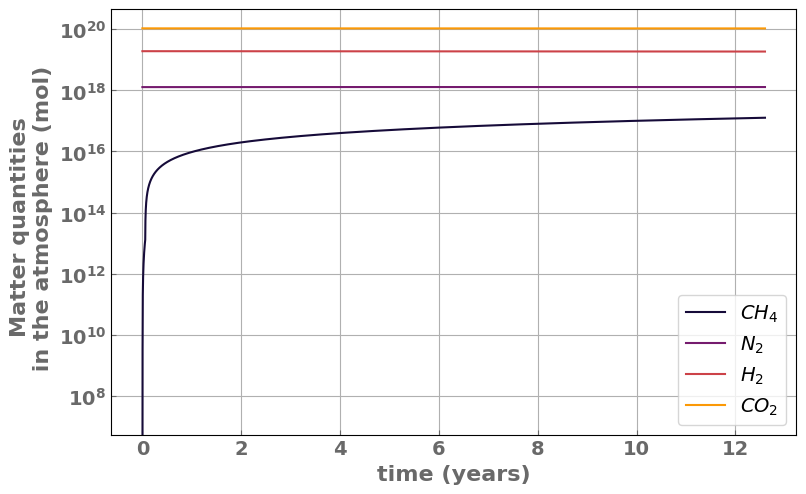

In [8]:
fig, ax = plt.subplots(1, 1)

ax.plot(big_time_list_years[::step] , big_ch4_atm_list[::step], label=r'${CH_4}$')
ax.plot(big_time_list_years[::step], big_n2_atm_list[::step], label=r'${N_2}$')
ax.plot(big_time_list_years[::step] , big_h2_atm_list[::step], label=r'${H_2}$')
ax.plot(big_time_list_years[::step] , big_co2_atm_list[::step], label=r'${CO_2}$')

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Matter quantities \n in the atmosphere (mol)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_atmo_nX.png",dpi=300,bbox_inches='tight')

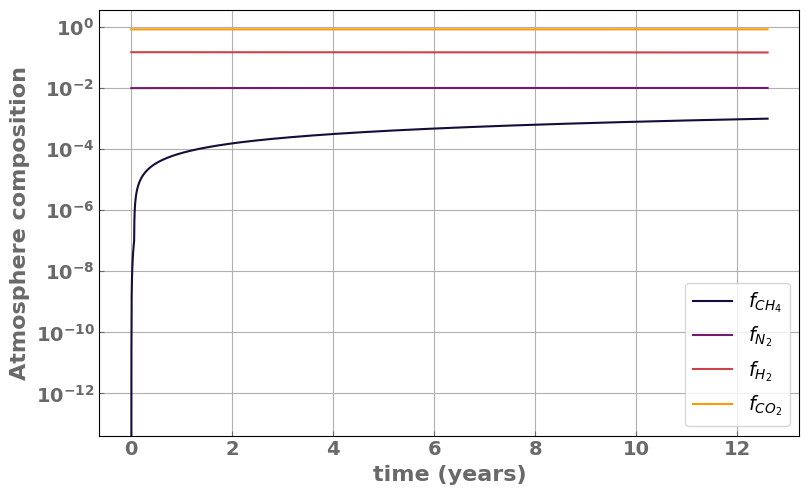

In [9]:
fig, ax = plt.subplots(1, 1)

ax.plot(big_time_list_years[::step] , big_ch4_atm_list[::step]/big_ntotatm[::step], label=r'$f_{CH_4}$')
ax.plot(big_time_list_years[::step], big_n2_atm_list[::step]/big_ntotatm[::step], label=r'$f_{N_2}$')
ax.plot(big_time_list_years[::step] , big_h2_atm_list[::step]/big_ntotatm[::step], label=r'$f_{H_2}$')
ax.plot(big_time_list_years[::step] , big_co2_atm_list[::step]/big_ntotatm[::step], label=r'$f_{CO_2}$')

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Atmosphere composition', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_atmo_fX.png",dpi=300,bbox_inches='tight')

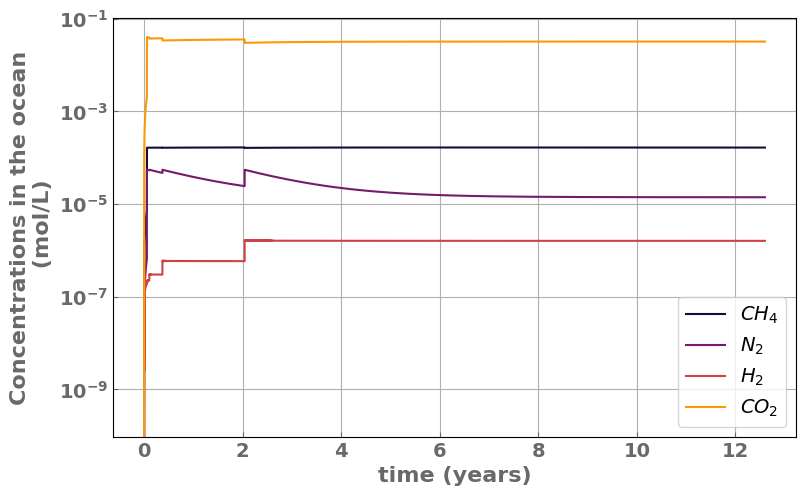

In [10]:
fig, ax = plt.subplots(1, 1)

ax.plot(big_time_list_years[::step] , np.array(big_ch4_wat_list)[::step]/(550*1e3*Mars_surface), label=r'${CH_4}$')
ax.plot(big_time_list_years[::step] , np.array(big_n2_wat_list)[::step]/(550*1e3*Mars_surface), label=r'${N_2}$')
ax.plot(big_time_list_years[::step] , np.array(big_h2_wat_list)[::step]/(550*1e3*Mars_surface), label=r'${H_2}$')
ax.plot(big_time_list_years[::step] , np.array(big_co2_wat_list)[::step]/(550*1e3*Mars_surface), label=r'${CO_2}$')

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Concentrations in the ocean\n (mol/L)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_ocean_concentrations.png",dpi=300,bbox_inches='tight')

C:\Users\fxmey\AppData\Local\Temp\ipykernel_1732\218655062.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=14, frameon=True)


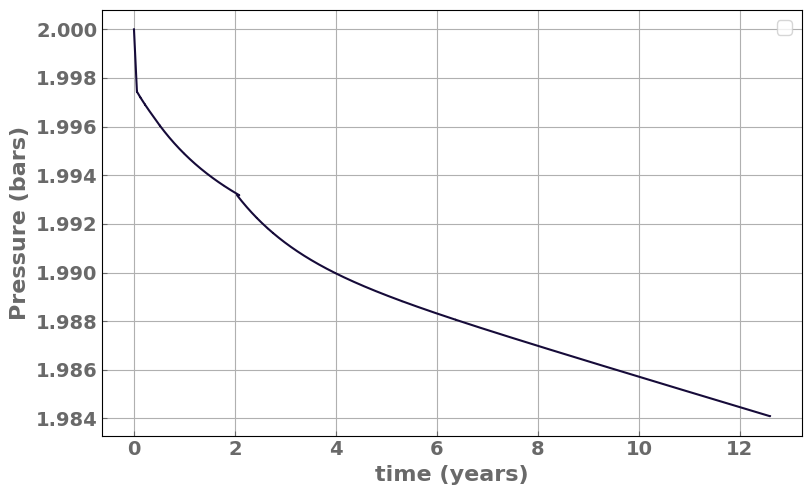

In [11]:
fig, ax = plt.subplots(1, 1)

ax.plot(big_timep_list_years[::step] , big_pressure_list[::step]/1e5)

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Pressure (bars)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_surface_pressure.png",dpi=300,bbox_inches='tight')

C:\Users\fxmey\AppData\Local\Temp\ipykernel_1732\1640690517.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=14, frameon=True)


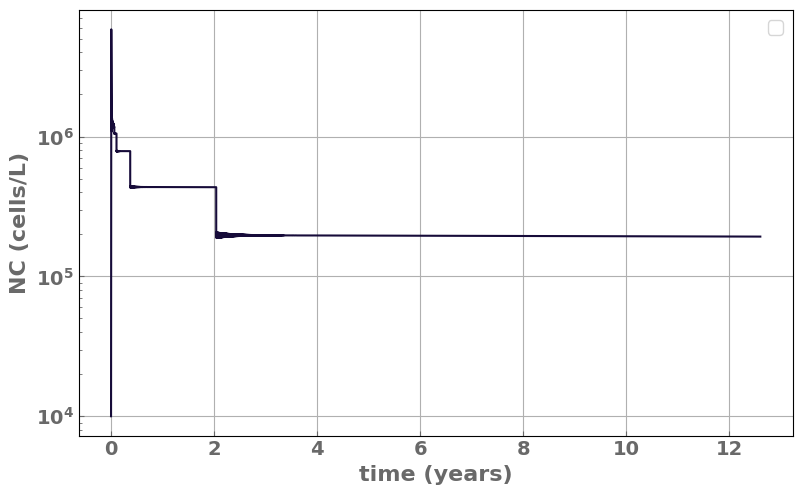

In [12]:
fig, ax = plt.subplots(1, 1)

# window_size = 50000
# kernel = np.ones(window_size) / window_size
# y_smooth = np.convolve(big_NC_list, kernel, mode='valid')

ax.plot(big_time_list_years, big_NC_list)
# ax.plot(big_time_list_years[:len(y_smooth)][::100] , y_smooth[::100],color='red')

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'NC (cells/L)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_cells_number.png",dpi=300,bbox_inches='tight')

C:\Users\fxmey\AppData\Local\Temp\ipykernel_1732\1069576071.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=14, frameon=True)


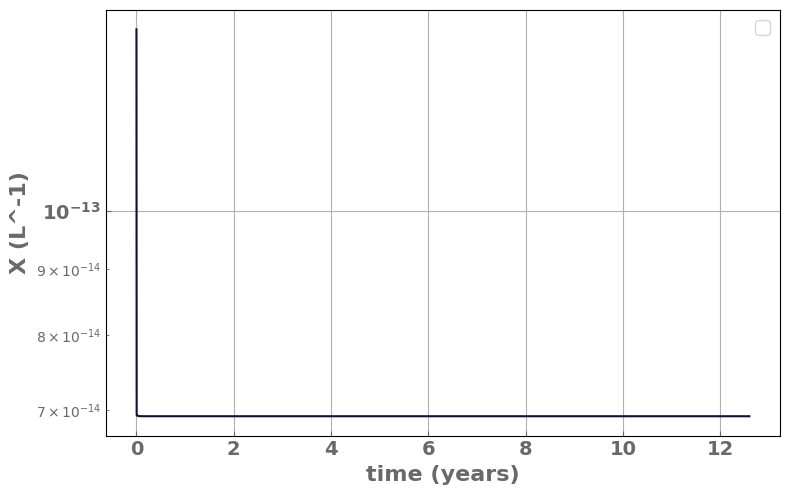

In [13]:
fig, ax = plt.subplots(1, 1)

# window_size = 50000
# kernel = np.ones(window_size) / window_size
# y_smooth = np.convolve(big_NC_list, kernel, mode='valid')

ax.plot(big_time_list_years, big_X_list)
# ax.plot(big_time_list_years[:len(y_smooth)][::100] , y_smooth[::100],color='red')

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'X (L^-1)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')


fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig(suff+"_1D_X.png",dpi=300,bbox_inches='tight')